<a href="https://colab.research.google.com/github/Allen9809/dl-lstm-stock-prediction/blob/main/dl_lstm_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction with RNN

In this project, I employ a Recurrent Neural Network (RNN) regressor to perform time series prediction, specifically forecasting Apple's stock price lag days into the future. I utilize a Long Short-Term Memory (LSTM) network architecture, which is particularly adept at addressing the optimization challenges typically associated with RNNs, ensuring more accurate and reliable predictions.

# Part 1: Data Loading

We begin by loading a historical dataset of Apple's stock prices, covering approximately 140 days. To prepare the data for the RNN model, several preprocessing steps are necessary. One crucial step is normalizing the time series data, which involves scaling the values to a range of [0, 1]. This normalization process helps mitigate numerical issues that can arise from the way activation functions, such as tanh, handle large values. It also ensures smoother gradient calculations during training. We will use the MinMaxScaler from scikit-learn to achieve this normalization

In [1]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2024-07-05 01:48:33--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M  --.-KB/s    in 0.1s    

2024-07-05 01:48:35 (210 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [2]:
!pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import yfinance as yf

In [4]:
# Download the latest TSLA stock data
tsla_data = yf.download('TSLA', start='2010-01-01', end='2024-07-04')
tsla_data[['Close']].to_csv('tsla_close_price.csv')

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Importing the training set
dataset = data = pd.read_csv('./tsla_close_price.csv')
dataset_cl = dataset.Close.values

In [6]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

# Part 2: Data Preprocessing

## Part 2.1: Cut our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [410]:
#Create a function to process the data into n day look back slices

lag = 20

def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, lag)


## Part 2.2: Train/test data split
To properly validate our model for time series prediction, we'll split the dataset into training and validation sets. Unlike typical random splits used in other machine learning tasks, we'll maintain the temporal relationship of the data:

- Training Set: This will consist of the first two-thirds of the dataset, ensuring our model learns from past data.
- Validation Set: This will be the last one-third of the dataset, used to evaluate the model's performance on unseen future data.
This approach simulates predicting future values of a time series, where we train on historical data and validate on subsequent time periods.

This method avoids training and testing on randomly shuffled data, which would not reflect the sequential nature of time series prediction tasks.

In [411]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

2804
702
2804
702


# Part 3:  RNN Model Building

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [412]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [451]:
import itertools

input_sizes = [lag]
hidden_sizes = [64, 128, 256]
num_layers = [1, 2]
output_sizes = [1]
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32, 64]

best_model = None
best_params = {}
best_loss = float('inf')
num_epochs_grid_search = 50

for (input_size, hidden_size, num_layer, output_size, learning_rate, batch_size) in itertools.product(input_sizes, hidden_sizes, num_layers, output_sizes, learning_rates, batch_sizes):

    rnn = RNN(input_size, hidden_size, num_layer, output_size, bidirectional=False).cuda()
    optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    X_test_cuda = torch.tensor(X_test, device='cuda').float()
    y_test_cuda = torch.tensor(y_test, device='cuda').float()

    inputs_cuda = torch.tensor(X_train, device='cuda').float()
    labels_cuda = torch.tensor(y_train, device='cuda').float()


    hidden_state = None

    train_history = []
    test_history = []

    for epoch in range(num_epochs_grid_search):
        rnn.train()
        output, _ = rnn(inputs_cuda, hidden_state)

        train_loss = criterion(output[:,0,:].view(-1), labels_cuda)
        optimiser.zero_grad()
        train_loss.backward()
        optimiser.step()

        rnn.eval()
        with torch.no_grad():
            test_output, _ = rnn(X_test_cuda, hidden_state)
            test_loss = criterion(test_output.view(-1), y_test_cuda)

        # print('epoch {}, train loss {}, test loss {}'.format(epoch, train_loss.item(), test_loss.item()))
        train_history.append(train_loss.item())
        test_history.append(test_loss.item())


    avg_test_loss = sum(test_history) / len(test_history)

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_params = {
            'input_size': input_size,
            'hidden_size': hidden_size,
            'num_layers': num_layer,
            'output_size': output_size,
            'learning_rate': learning_rate,
            'batch_size': batch_size
        }
        best_model = rnn

print("Best Parameters:")
print(best_params)
print("Best Average Test Loss:", best_loss)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Best Parameters:
{'input_size': 20, 'hidden_size': 64, 'num_layers': 1, 'output_size': 1, 'learning_rate': 0.01, 'batch_size': 32}
Best Average Test Loss: 0.005754573326557874


In [458]:
# Globals
INPUT_SIZE = best_params['input_size']
HIDDEN_SIZE = best_params['hidden_size']
NUM_LAYERS = best_params['num_layers']
OUTPUT_SIZE = best_params['output_size']
BATCH_SIZE = best_params['batch_size']
learning_rate = best_params['learning_rate']
num_epochs = 200  # Number of epochs for training

# Create the model and move it to CUDA
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False).cuda()
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Prepare data (assuming you have X_train, y_train, X_test, y_test)
X_test_cuda = torch.tensor(X_test, device='cuda').float()
y_test_cuda = torch.tensor(y_test, device='cuda').float()

inputs_cuda = torch.tensor(X_train, device='cuda').float()
labels_cuda = torch.tensor(y_train, device='cuda').float()

# Initialize hidden state if needed
hidden_state = None

train_history = []
test_history = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    rnn.train()

    # Forward pass
    output, _ = rnn(inputs_cuda, hidden_state)

    # Compute training loss
    train_loss = criterion(output[:,0,:].view(-1), labels_cuda)

    # Backward pass and optimization step
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

    # Evaluate on the test set every epoch
    # Set the model to evaluation mode
    rnn.eval()
    with torch.no_grad():
        # Forward pass on the test set
        test_output, _ = rnn(X_test_cuda, hidden_state)

        # Compute test loss
        test_loss = criterion(test_output.view(-1), y_test_cuda)

    # Print and store losses
    print('epoch {}, train loss {}, test loss {}'.format(epoch, train_loss.item(), test_loss.item()))
    train_history.append(train_loss.item())
    test_history.append(test_loss.item())

# Training complete, you can proceed with evaluation or other tasks


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


epoch 0, train loss 0.023851808160543442, test loss 0.031802184879779816
epoch 1, train loss 0.005281689111143351, test loss 0.04800482839345932
epoch 2, train loss 0.003725549904629588, test loss 0.006282496731728315
epoch 3, train loss 0.0027741591911762953, test loss 0.0063009439036250114
epoch 4, train loss 0.0003732028999365866, test loss 0.00854021217674017
epoch 5, train loss 0.0013059360207989812, test loss 0.010602324269711971
epoch 6, train loss 0.002011198317632079, test loss 0.012123582884669304
epoch 7, train loss 0.0015945557970553637, test loss 0.011650582775473595
epoch 8, train loss 0.0008691330440342426, test loss 0.008810611441731453
epoch 9, train loss 0.0004363574553281069, test loss 0.005848593078553677
epoch 10, train loss 0.00044691486982628703, test loss 0.005813324358314276
epoch 11, train loss 0.0007319595315493643, test loss 0.008023818023502827
epoch 12, train loss 0.000943383842241019, test loss 0.008412227034568787
epoch 13, train loss 0.00081218022387474

# Part 4: Model Evaluation


In [459]:
rnn.training

False

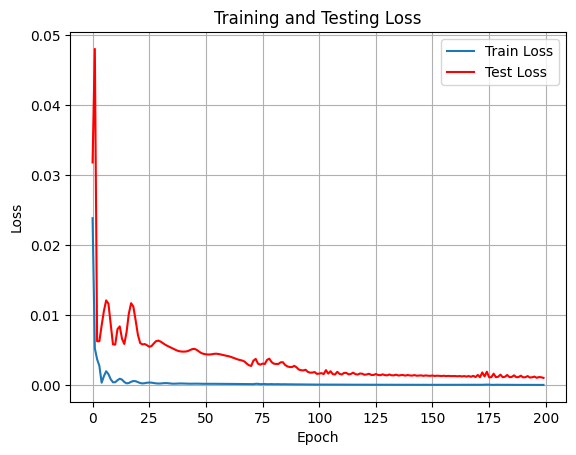

In [460]:
plt.plot(train_history, label='Train Loss')
plt.plot(test_history, 'r-', label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


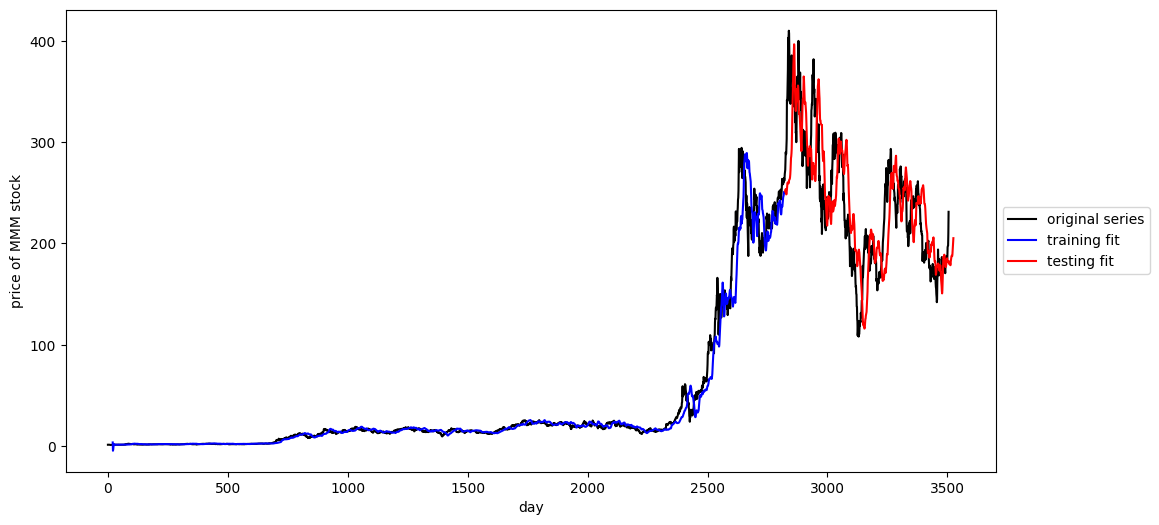

In [461]:
plt.figure(figsize=(12, 6))

# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + lag # window_size
plt.plot(np.arange(lag, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


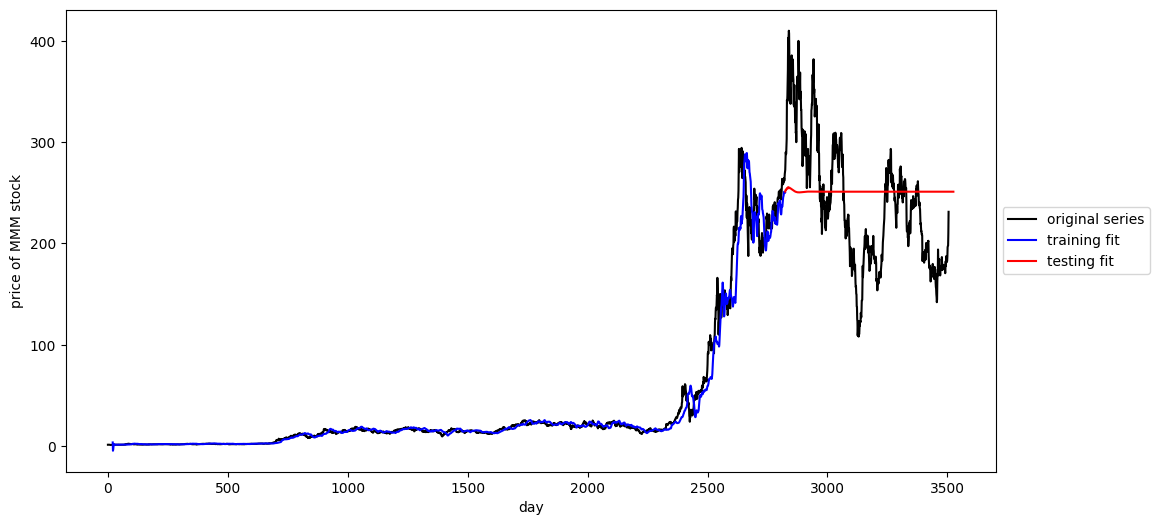

In [462]:
plt.figure(figsize=(12, 6))

# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1, 1)), color='k')

# Initial input and prediction using X_test_cuda[0]
next_input = X_test_cuda[0].reshape(1, 1, -1)
next_pred, hidden_state = rnn(next_input.cuda(), hidden_state)
next_pred_cpu = next_pred.cpu().detach().numpy()

# Store predictions for plotting
predictions = [next_pred_cpu[0, 0]]

# Predict subsequent values based on previous predictions
for i in range(1, len(X_test_cuda)):
    # Append the latest prediction to the input sequence, drop the first element
    next_input = torch.cat((next_input[:, :, 1:], next_pred), dim=2)

    # Predict using the updated input sequence
    next_pred, hidden_state = rnn(next_input.cuda(), hidden_state)
    next_pred_cpu = next_pred.cpu().detach().numpy()

    # Store the prediction
    predictions.append(next_pred_cpu[0, 0])

# Plotting
split_pt = int(X.shape[0] * 0.80) + lag # window_size
plt.plot(np.arange(lag, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1, 1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(predictions), 1), sc.inverse_transform(np.array(predictions).reshape(-1, 1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series', 'training fit', 'testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


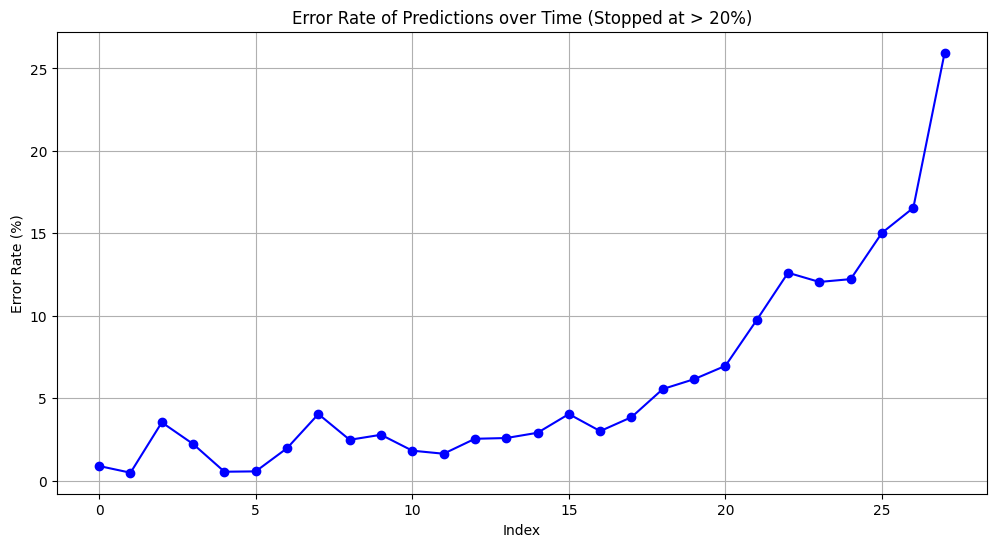

Stopped at index 28, representing 28 steps before error rate exceeded 20%.


In [463]:
# Initialize variables
predictions = []
error_rates = []

# Initial input and prediction using X_test_cuda[0]
next_input = X_test_cuda[0].reshape(1, 1, -1)
next_pred, hidden_state = rnn(next_input, hidden_state)
next_pred_cpu = next_pred.cpu().detach().numpy()

# Store initial prediction
predictions.append(next_pred_cpu[0, 0])

# Predict subsequent values based on previous predictions
stop_index = None
for i in range(1, len(X_test_cuda)):
    # Append the latest prediction to the input sequence, drop the first element
    next_input = torch.cat((next_input[:, :, 1:], next_pred), dim=2)

    # Predict using the updated input sequence
    next_pred, hidden_state = rnn(next_input.cuda(), hidden_state)
    next_pred_cpu = next_pred.cpu().detach().numpy()

    # Store the prediction
    predictions.append(next_pred_cpu[0, 0])

    # Calculate inverse transformed actual and predicted values
    start_index = split_pt - lag
    end_index = split_pt + i - lag
    y_actual = sc.inverse_transform(y.reshape(-1, 1))[start_index:end_index].flatten()
    y_pre = sc.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Calculate error rate for the current prediction
    absolute_error = np.abs(y_pre[-1] - y_actual[-1])
    current_error_rate = absolute_error / y_actual[-1]
    error_rates.append(current_error_rate)

    # Check if error rate exceeds 20%
    if current_error_rate > 0.2:
        stop_index = i
        break

# Convert error_rates to numpy array
error_rates = np.array(error_rates)

# Plotting the error rates over index
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(error_rates)), error_rates * 100, marker='o', linestyle='-', color='b')

# Pretty up graph
plt.xlabel('Index')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate of Predictions over Time (Stopped at > 20%)')
plt.grid(True)
plt.show()

# Print the index where error rate first exceeds 20%
if stop_index is not None:
    print(f"Stopped at index {stop_index}, representing {stop_index} steps before error rate exceeded 20%.")
else:
    print("Error rate did not exceed 20% within the tested range.")


LSTM models, while commonly used for stock price prediction, exhibit significant limitations. One notable drawback is their susceptibility to lag effects, where the model's predictions often lag behind actual stock prices, resulting in a rightward 'shift' in the predicted trends compared to real data. This lag undermines the model's ability to accurately capture real-time fluctuations and trends in stock prices, thereby impacting its predictive reliability.

Transformers present several advantages over LSTM models when applied to stock price prediction. Unlike LSTMs, transformers can capture complex, long-range dependencies in data without being affected by sequential processing limitations. This ability is crucial for analyzing the intricate and often non-linear relationships present in stock price movements. Transformers excel in learning contextual relationships across the entire historical price series, allowing them to potentially forecast future trends more accurately and promptly.